<h1>Dados Covid-19 - Pré-processamento</h1>

Dados obtidos do site <a href="https://brasil.io">Brasil.io</a>. O qual disponibiliza não apenas os dados como também documentação, diversas visualizações dos dados, uma API de acesso além do código fonte de tudo.

URL direta dos dados: <a href="https://brasil.io/dataset/covid19/files/">https://brasil.io/dataset/covid19/files/</a>.

Data de download: 02/03/2021 

<h2>Média Móvel Semanal</h2>

Carga da biblioteca gráfica:

In [1]:
library("ggplot2")

Carga dos dados.

In [2]:
dados <- read.csv("../input/covid19/caso.csv", header = TRUE, stringsAsFactors = FALSE)

Vamos manter apenas os dados necessários:

In [3]:
dados <- dados[dados$state == "RJ" & dados$place_type == "city", ]
dados <- dados[ , - c(2, 4, 9)] # state, place_type, estimated_population_2019
dados <- dados[dados$city != "Importados/Indefinidos", ]

<h3>Número de mortes por dia</h3>

In [4]:
dados$deaths_day <- 0

municipios <- sort(unique(dados$city))

for (municipio in municipios) {
  indices <- sort(dados[dados$city == municipio, "order_for_place"])
  acumulado <- 0
  for (indice in indices) {
    mortes_no_dia <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"] - acumulado
    dados[dados$city == municipio & dados$order_for_place == indice, "deaths_day"] <- mortes_no_dia
    acumulado <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"]
  }
}

<h3>Média móvel semanal</h3>
A média móvel semanal faz, para cada dia, a média dos sete últimos dias. Isso diminui o efeito de outliers, como atrasos de notificações divulgados todos em um dia, suavisando picos e permitindo observar tendências.


Primeiro todos tem de ter o mesmo numero de datas

In [5]:
# seleciona apenas colunas de interesse
temp <- dados[ , c(1,2,11)] # date, city, deaths_day

# todas as datas que existem no conjunto de dados
datas <- sort(unique(temp$date))

linha <- nrow(temp)
for (municipio in municipios) {
  for (data in datas) {
    if (nrow(temp[temp$city == municipio & temp$date == data,]) == 0) {
      linha <- linha + 1
      temp[(linha), "date"] <- data
      temp[(linha), "city"] <- municipio
      temp[(linha), "deaths_day"] <- 0 
    }
  }
}

Agora o cálculo da média móvel:

In [6]:
# Semanas, cidades e média de mortes de cada semana:
media_movel <- data.frame(date = 0, city = "", deaths_day=0, rolling_7_day_average = 0, stringsAsFactors = FALSE)

municipios <- sort(unique(temp$city))
datas <- sort(unique(temp$date))

i <- 1  # linhas de media_movel
for (municipio in municipios) {
  ultimos_dias <- rep(0, 7)
  j <- 1  # indice de elementos do municipio
  for (data in datas) {
    valor <- 0
    registro <- temp[temp$city == municipio & temp$date == data, ]
    if (nrow(registro) > 0) {
      valor <- registro[1, "deaths_day"]
    }
    
    ultimos_dias[j %% 7 + 1] <- valor
    if (j >= 7) {
      media_movel[i, "rolling_7_day_average"] <- mean(ultimos_dias)
    } else {
      media_movel[i, "rolling_7_day_average"] <- sum(ultimos_dias) / j
    }
    
    media_movel[i, "date"] <- data
    media_movel[i, "city"] <- municipio
    media_movel[i, "deaths_day"] <- valor
    
    i <- i + 1
    j <- j + 1
  }
}

O gráfico de todo o conjunto de dados:

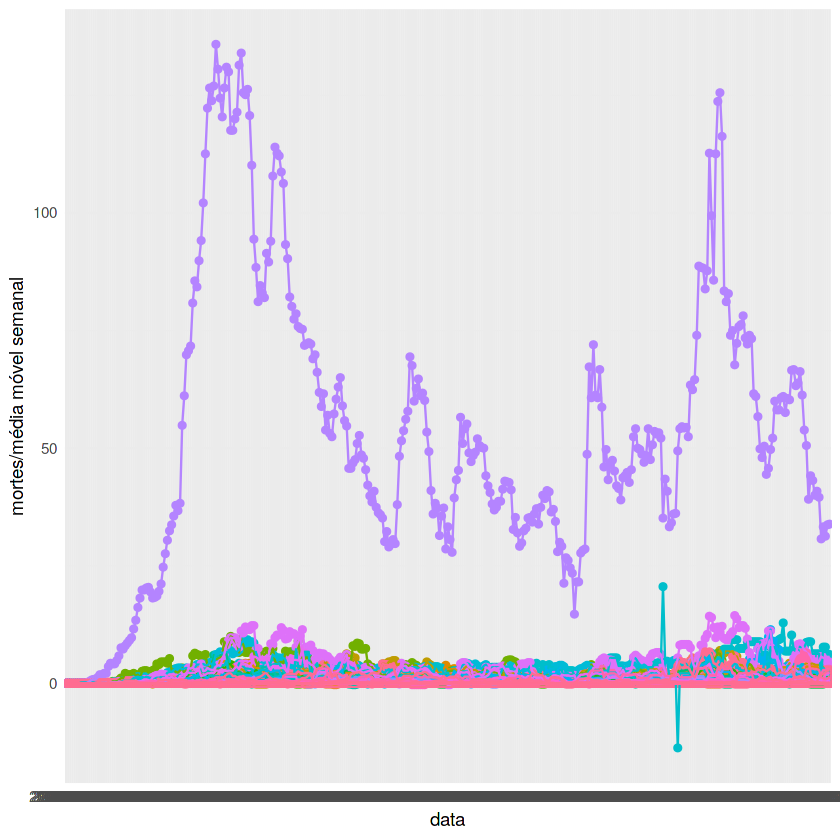

In [7]:
ggplot(media_movel, aes(x=date, y=rolling_7_day_average, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "data", y = "mortes/média móvel semanal") +
  theme_minimal()

Gráfico do Rio de Janeiro com número de mortes diárias e a média móvel semanal:

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



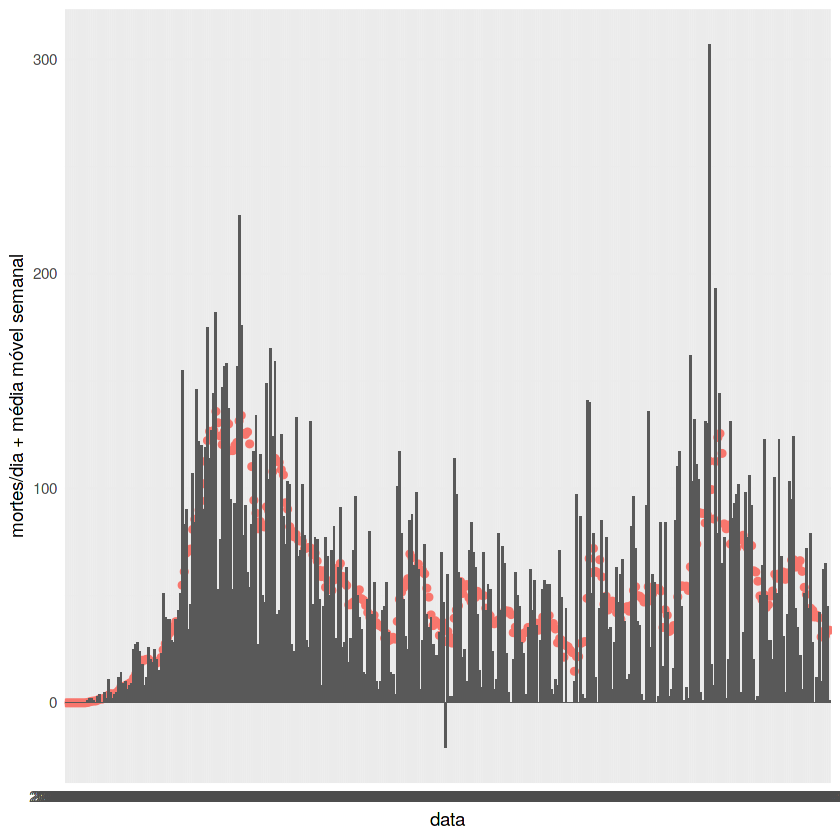

In [8]:
ggplot(media_movel[media_movel$city == "Rio de Janeiro", ], aes(x=date, y=rolling_7_day_average)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  geom_col(aes(y=deaths_day), show.legend = FALSE) +
  labs(x = "data", y = "mortes/dia + média móvel semanal") +
  theme_minimal()

<h4>Variação da média móvel (14 dias)</h4>
Mudança da média móvel nos últimos 14 dias. Essa mudança pode inidicar tendência de alta (>= 15%), estabilidade (variações de até 15% positiva ou negativa), ou queda (<= -15%). Para isso, é preciso calcular a variação percentual das médias móveis em intervalos de 14 dias.

In [9]:
media_movel$percentage_change <- 0

municipios <- sort(unique(temp$city))
datas <- sort(unique(temp$date))

for (municipio in municipios) {
  ultimos_dias <- rep(0, 14)
  i <- 1 # indice de elementos do municipio
  for (data in datas) {
    valor_hoje <- media_movel[media_movel$city == municipio & media_movel$date == data, "rolling_7_day_average"]
    ultimos_dias[i %% 14 + 1] <- valor_hoje
    
    mudanca_percentual <- 0
    if (valor_hoje != 0) {
      if (i > 14) {
        mudanca_percentual <- valor_hoje / ultimos_dias[(i + 1) %% 14 + 1] - 1
      } else {
        mudanca_percentual <- valor_hoje / ultimos_dias[2] - 1
      }
      
      if (is.infinite(mudanca_percentual)) {  # divisao por zero (Inf)?
        mudanca_percentual <- 0
      }
    }
    media_movel[media_movel$city == municipio & media_movel$date == data, "percentage_change"] <- mudanca_percentual
    
    i <- i + 1
  }
}

O gráfico:

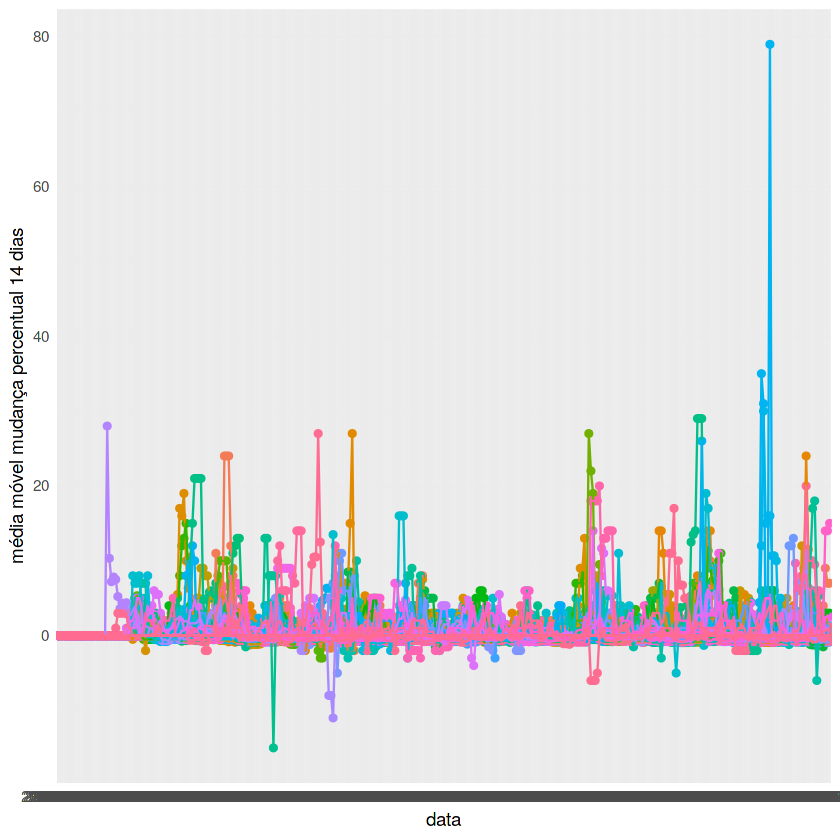

In [10]:
ggplot(media_movel, aes(x=date, y=percentage_change, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "data", y = "média móvel mudança percentual 14 dias") +
  theme_minimal()

<h4>Tendência da média móvel (14 dias)</h4>

In [11]:
tendencia <- function(x) {
  if (x > 0.15) {
    return(1)
  }
  if (x < -0.15) {
    return(-1)
  }
  return(0)
}

media_movel$trend <- unlist(lapply(media_movel$percentage_change,  FUN = tendencia))

O gráfico:

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



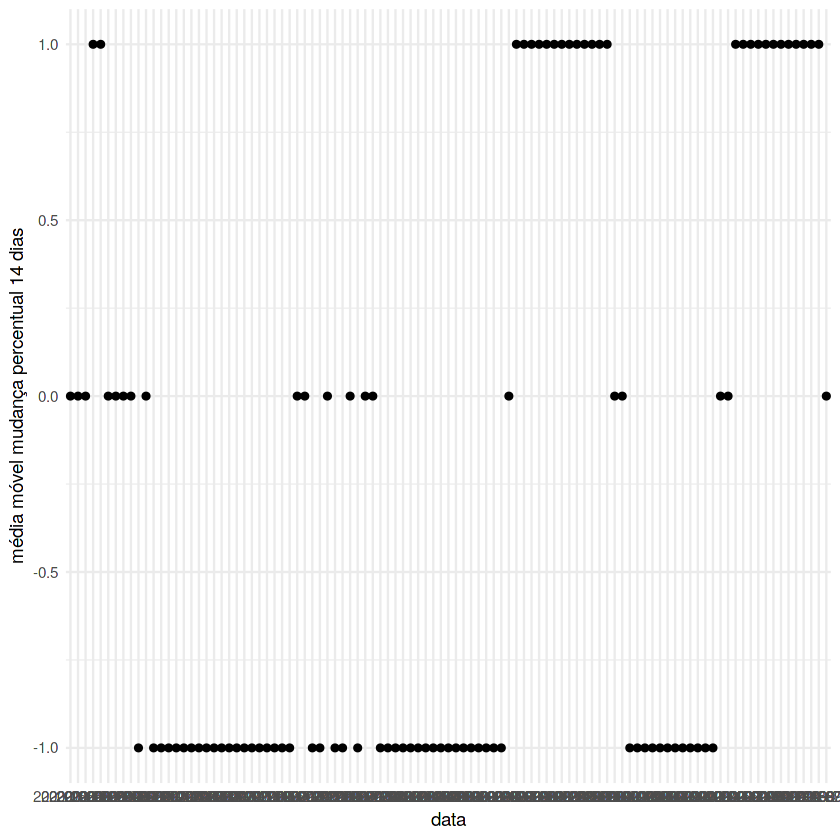

In [12]:
ggplot(media_movel[media_movel$city == "Rio de Janeiro" & media_movel$date %in% datas[100:200], ], aes(x=date, y=trend)) +
  geom_point(show.legend = FALSE) +
  geom_line(show.legend = FALSE) +
  labs(x = "data", y = "média móvel mudança percentual 14 dias") +
  theme_minimal()